In [1]:
import librosa
import numpy as np
import glob, os
from scipy.stats import iqr
import soundfile as sf
from concurrent.futures import ThreadPoolExecutor, as_completed

sr = 22050

def load_wav(directory, max_files = 15, sr = 22050):

    audio_files = []

    directory = directory
    max_files = max_files
    sr = sr

    for file_number in range(1, max_files + 1):
        directory_path = directory + str(f"/0{file_number}" if file_number < 10 else f"/{file_number}")
        wav_paths = glob.glob(os.path.join(directory_path, '*.wav'))
        audio_files += [librosa.load(wav_path, sr = sr)[0] for wav_path in wav_paths]

    max_length = sr
    audio_files = np.array([np.pad(arr, (0, max_length - len(arr)), 'constant') for arr in audio_files])
    return audio_files, sr




def get_spectrograms(data, hop_length = 512, frame_size = 2048, normalize = True):
    specs = np.array([librosa.stft(y = y, hop_length = hop_length, n_fft = frame_size) for y in data])
    #if normalize:
    new_data = librosa.amplitude_to_db(S = np.abs(specs), ref = np.max)
    #new_data = (new_data - new_data.min()) / (new_data.max() - new_data.min())
    new_data = np.array([(x - x.min()) / (x.max() - x.min()) for x in new_data])
    return new_data

def extract_features(dataset, sr, n_mels=128, n_fft=2048, hop_length=512):
    mel_spec = np.array([librosa.feature.melspectrogram(y = data, sr=sr, n_mels=n_mels, n_fft=n_fft, hop_length=hop_length) for data in dataset])
    mel_spec_db = np.array([librosa.power_to_db(spec, ref=np.max) for spec in mel_spec])
    return mel_spec_db

def normalize(data, type = 'standardization'):
    if type == 'standardization':
        return np.array([(x - np.mean(x)) / np.std(x) for x in data])
    if type == 'minmax':
        return np.array([(x - np.min(x)) / (np.max(x) - np.min(x)) for x in data])
    if type == 'robust':
        return np.array([(x - np.median(x)) / iqr(x) for x in data])

def denormalize(data):
    return data * (data.max() - data.min()) + data.min()


In [31]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Define the encoder
def build_encoder(input_shape, latent_dim):
    inputs = layers.Input(shape=input_shape)
    x = layers.Conv2D(8, (5, 5), strides = (2, 1), activation='relu', padding='valid')(inputs)
    x = layers.MaxPool2D((2, 2), padding='same')(x)
    x = layers.Conv2D(64, (5, 5), strides = (2, 1), activation='relu', padding='valid')(x)
    x = layers.MaxPool2D((2, 2), padding='same')(x)
    x = layers.Flatten()(x)
    x = layers.Dense(64, activation='relu')(x)
    z_mean = layers.Dense(latent_dim)(x)
    z_log_var = layers.Dense(latent_dim)(x)
    return models.Model(inputs, [z_mean, z_log_var], name='encoder')

# Define the decoder
def build_decoder(latent_dim, output_shape):
    latent_inputs = layers.Input(shape=(latent_dim,))
    x = layers.Dense(np.prod(output_shape), activation='relu')(latent_inputs) # 10160
    x = layers.Reshape(target_shape = output_shape)(x) # (127, 20, 4)
    x = layers.UpSampling2D((2, 2))(x)
    x = layers.Conv2DTranspose(32, (2, 3), strides = (1, 1), activation='relu', padding='valid')(x)
    x = layers.UpSampling2D((2, 2))(x)
    outputs = layers.Conv2DTranspose(1, (4, 4), strides = (1, 1), activation='relu', padding='valid')(x)
    return models.Model(latent_inputs, outputs, name='decoder')


In [27]:
x = np.array([[1., 2., 3.],
              [4., 5., 6.],
              [7., 8., 9.]])
x = np.reshape(x, [1, 3, 3, 1])
max_pool_2d = tf.keras.layers.MaxPool2D(pool_size=(2, 2),
   strides=(1, 1), padding="valid")
max_pool_2d(x)

<tf.Tensor: shape=(1, 2, 2, 1), dtype=float32, numpy=
array([[[[5.],
         [6.]],

        [[8.],
         [9.]]]], dtype=float32)>

In [3]:
import tensorflow as tf
from sklearn.model_selection import train_test_split

directory_path = "C:/Users/damia/AudioMNIST/data/"
hop_length = 256
frame_size = 1024

y, sr = load_wav(directory_path, max_files = 1)
spectrograms = get_spectrograms(y, hop_length = hop_length, frame_size = frame_size, normalize = True)

X_train, X_test, _, _ = train_test_split(spectrograms, np.random.rand(y.shape[0],), random_state= 12, shuffle = True, test_size = 0.33)
X_train = X_train.reshape(*X_train.shape, 1)
X_test = X_test.reshape(*X_test.shape, 1)

In [32]:
import vae
# Instantiate and compile the VAE
input_shape = (513, 87, 1)  # Example input shape, should match your preprocessed data
latent_dim = 32
output_shape = (127, 20, 4)
encoder = build_encoder(input_shape, latent_dim)
decoder = build_decoder(latent_dim, output_shape)
vae_model = vae.VAE(encoder, decoder)
batch_size = 16
vae_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 1e-2))

Epoch 1/3
21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 131ms/step - kl_loss: 4.4953e-07 - reconstruction_loss: 0.0121 - total_loss: 0.0121
Epoch 2/3
21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 128ms/step - kl_loss: 2.9865e-07 - reconstruction_loss: 0.0120 - total_loss: 0.0120
Epoch 3/3
21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 132ms/step - kl_loss: 4.1354e-07 - reconstruction_loss: 0.0120 - total_loss: 0.0120
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step


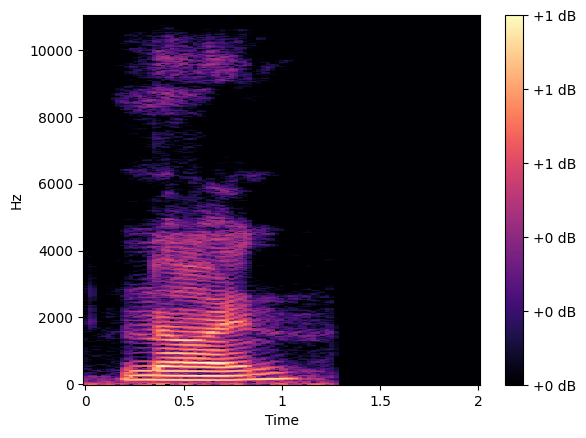

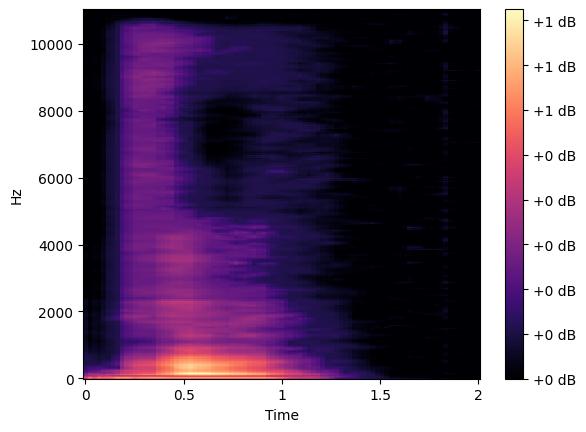

In [38]:
import matplotlib.pyplot as plt
# Train the VAE
vae_model.fit(X_train, epochs=150, batch_size = batch_size)


fig, ax = plt.subplots()
img = librosa.display.specshow(X_test[0].reshape(X_test[0].shape[0], X_test[0].shape[1]), x_axis='time', y_axis='linear', ax=ax)
fig.colorbar(img, ax=ax, format="%+2.f dB")
reconstructed_audio = vae_model.predict(spectrograms[:111].reshape(*spectrograms[:111].shape, 1))


fig, ax = plt.subplots()
img = librosa.display.specshow(reconstructed_audio[0].reshape(reconstructed_audio[0].shape[0], reconstructed_audio[0].shape[1]), x_axis='time', y_axis='linear', ax=ax)
fig.colorbar(img, ax=ax, format="%+2.f dB")

sf.write("C:/Users/damia/test_audio/audio.wav", librosa.istft(spectrograms[1]), samplerate=sr)
sf.write("C:/Users/damia/test_audio/audio_recon.wav", librosa.istft(reconstructed_audio[1].reshape(reconstructed_audio[1].shape[0], reconstructed_audio[1].shape[1]), hop_length=256, n_fft=1024), samplerate = sr)

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 156ms/step


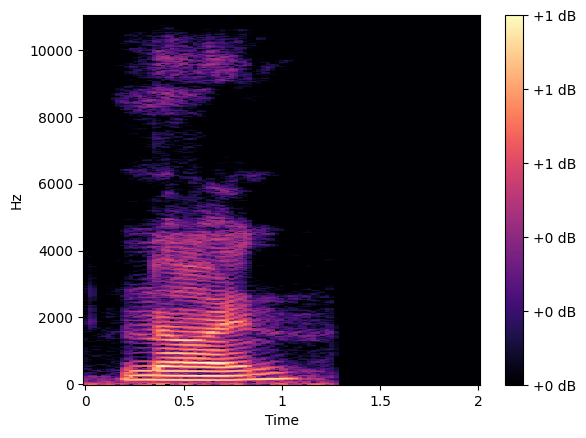

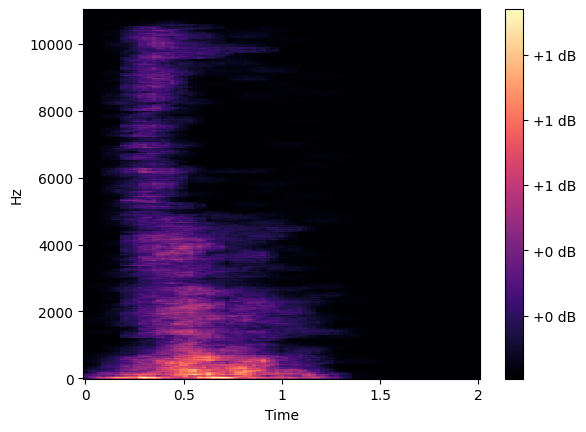

In [6]:
import matplotlib.pyplot as plt

def reconstruct_audio(vae, audio_features):
    reconstructed_features = vae.predict(audio_features[np.newaxis, ..., np.newaxis])
    reconstructed_features = reconstructed_features[0, ..., 0]
    return reconstructed_features

fig, ax = plt.subplots()
img = librosa.display.specshow(X_test[0].reshape(X_test[0].shape[0], X_test[0].shape[1]), x_axis='time', y_axis='linear', ax=ax)
fig.colorbar(img, ax=ax, format="%+2.f dB")

reconstructed_audio = vae_model.predict(spectrograms[:122].reshape(*spectrograms[:122].shape, 1))[0]


fig, ax = plt.subplots()
img = librosa.display.specshow(reconstructed_audio.reshape(reconstructed_audio.shape[0], reconstructed_audio.shape[1]), x_axis='time', y_axis='linear', ax=ax)
fig.colorbar(img, ax=ax, format="%+2.f dB")

sf.write("C:/Users/damia/test_audio/audio.wav", y[3] / y[3].max(), samplerate=sr)
sf.write("C:/Users/damia/test_audio/audio_recon.wav", librosa.griffinlim(S = reconstructed_audio.reshape(reconstructed_audio.shape[0], reconstructed_audio.shape[1]), hop_length=256, n_fft=1024), samplerate = sr)